In [1]:
# prerequisites
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda, concatenate
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.utils import to_categorical
from scipy.stats import norm

C:\Users\lyeoni\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# data load
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr, x_te = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)
print(x_tr.shape, x_te.shape)

# one-hot encoding
y_tr, y_te = to_categorical(y_tr), to_categorical(y_te)
print(y_tr.shape, y_te.shape)

# network parameters
batch_size, n_epoch = 50, 50
n_hidden, z_dim = 512, 2

(60000, 784) (10000, 784)
(60000, 10) (10000, 10)


In [3]:
# encoder
x = Input(shape=(x_tr.shape[1:]))
condition = Input(shape=(y_tr.shape[1],))

inputs = concatenate([x, condition])
x_encoded = Dense(n_hidden, activation='relu')(inputs)
x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)
mu = Dense(z_dim, activation='linear')(x_encoded)
log_var = Dense(z_dim, activation='linear')(x_encoded)

In [4]:
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var/2.) * eps

z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])
z_cond = concatenate([z, condition])

In [5]:
# decoder
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr.shape[1], activation='sigmoid')

z_decoded = z_decoder1(z_cond)
z_decoded = z_decoder2(z_decoded)
y = y_decoder(z_decoded)

In [6]:
# loss
reconstruction_loss = objectives.binary_crossentropy(x, y) * x_tr.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
cvae_loss = reconstruction_loss + kl_loss

# build model
cvae = Model([x, condition], y)
cvae.add_loss(cvae_loss)
cvae.compile(optimizer='adam')
cvae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 794)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          407040      concatenate_1[0][0]              
__________

C:\Users\lyeoni\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Output "dense_7" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_7" during training.
  if __name__ == '__main__':


In [7]:
# train
cvae.fit([x_tr, y_tr],
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=([x_te, y_te], None), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 8s 133us/step - loss: 152.9767 - val_loss: 138.5936
Epoch 2/50
60000/60000 [==============================] - 5s 85us/step - loss: 136.4014 - val_loss: 135.3060
Epoch 3/50
60000/60000 [==============================] - 5s 85us/step - loss: 133.8727 - val_loss: 133.6277
Epoch 4/50
60000/60000 [==============================] - 5s 86us/step - loss: 132.5169 - val_loss: 132.4926
Epoch 5/50
60000/60000 [==============================] - 5s 86us/step - loss: 131.6566 - val_loss: 131.7776
Epoch 6/50
60000/60000 [==============================] - 5s 84us/step - loss: 130.9849 - val_loss: 131.4533
Epoch 7/50
60000/60000 [==============================] - 5s 86us/step - loss: 130.4800 - val_loss: 130.7129
Epoch 8/50
60000/60000 [==============================] - 5s 85us/step - loss: 129.9974 - val_loss: 130.5059
Epoch 9/50
60000/60000 [==============================] - 5s 85us/step - loss

In [8]:
# build encoder
encoder = Model([x, condition], mu)
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 794)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          407040      concatenate_1[0][0]              
__________

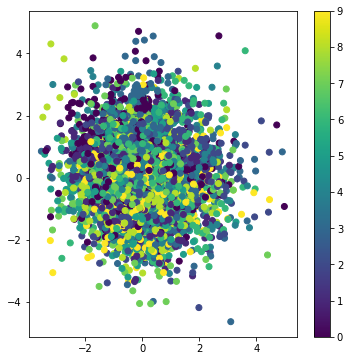

In [9]:
# Plot of the digit classes in the latent space
te_latent = encoder.predict([x_te, y_te], batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(te_latent[:, 0], te_latent[:, 1], c=np.argmax(y_te, axis=1))
plt.colorbar()
plt.show()

In [10]:
# build decoder
decoder_input = Input(shape=(z_dim+y_tr.shape[1],))
_z_decoded = z_decoder1(decoder_input)
_z_decoded = z_decoder2(_z_decoded)
_y = y_decoder(_z_decoded)
generator = Model(decoder_input, _y)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 12)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               3328      
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_7 (Dense)              (None, 784)               402192    
Total params: 537,104
Trainable params: 537,104
Non-trainable params: 0
_________________________________________________________________


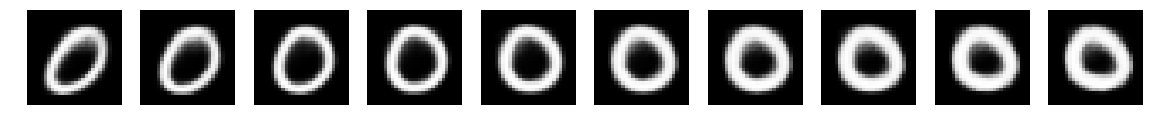

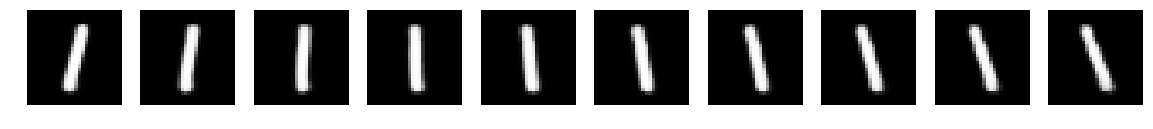

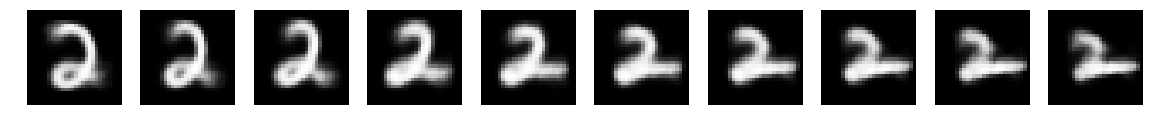

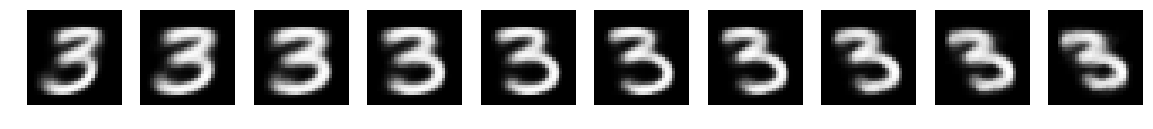

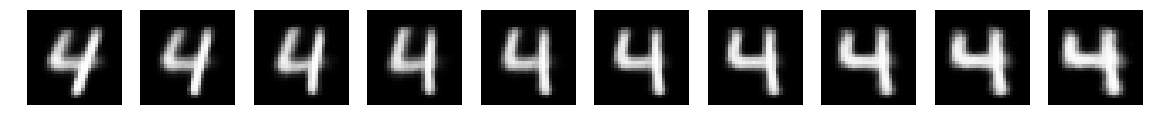

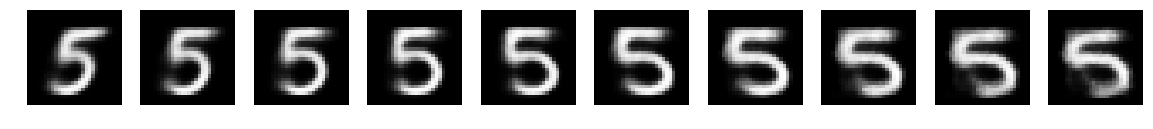

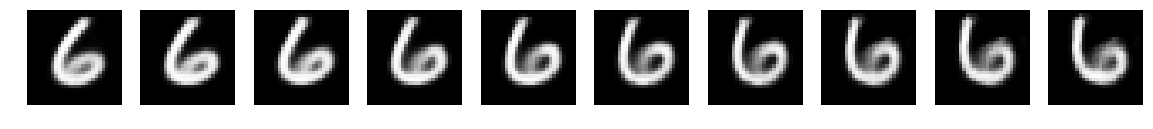

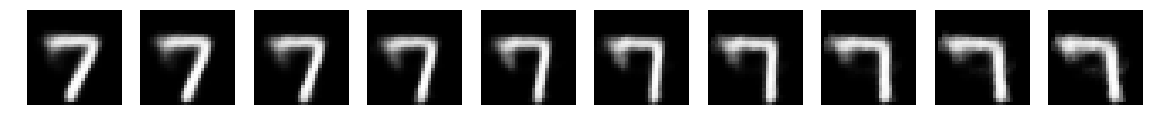

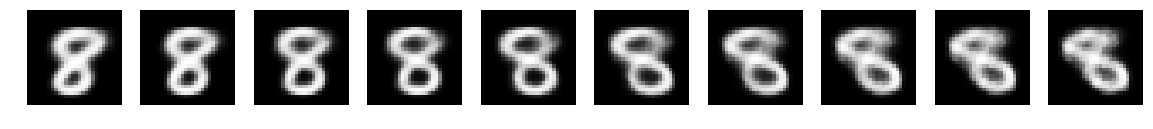

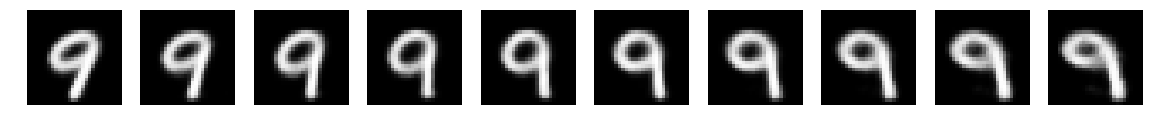

In [11]:
# exploring the latent space: change z sample on the x-axis
digit_size = 28
for cond_num in range(10):
    condition_num = to_categorical(cond_num, 10).reshape(1,-1)
    plt.figure(figsize=(20, 2))

    for i in range(10):
        z_sample = np.array([[0.3*i, 0.3]])
        x_decoded = generator.predict(np.column_stack([z_sample, condition_num]))
        digit = x_decoded[0].reshape(digit_size, digit_size)

        plt.subplot(1, 10, i+1)
        plt.axis('off')
        plt.imshow(digit, cmap='Greys_r',)

plt.show()

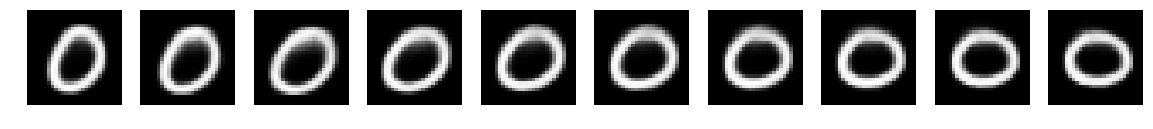

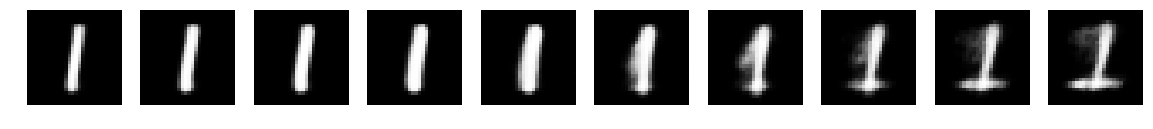

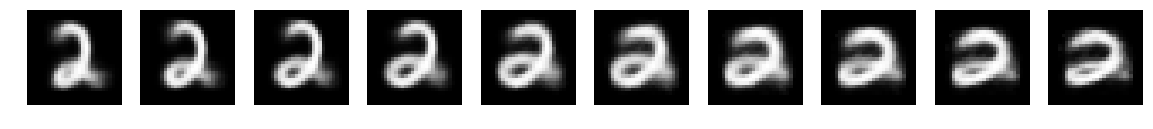

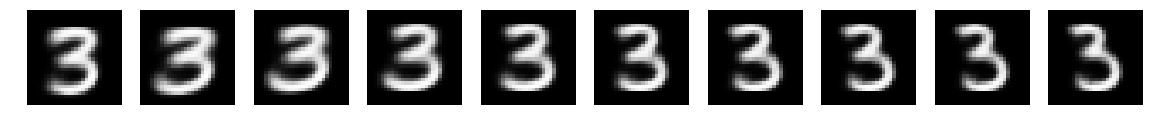

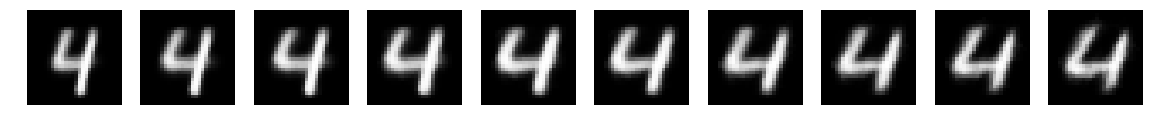

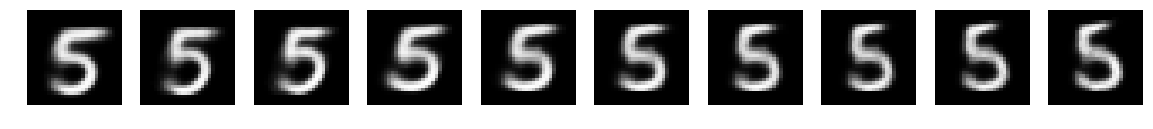

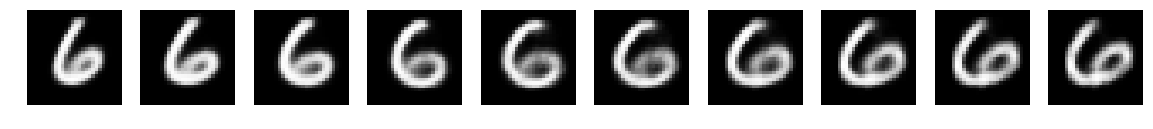

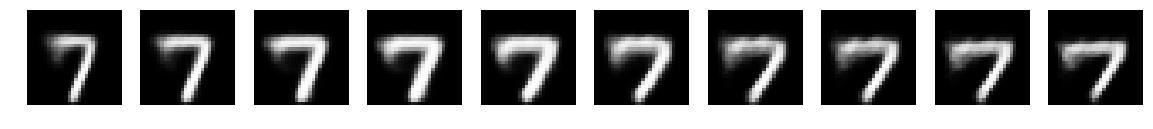

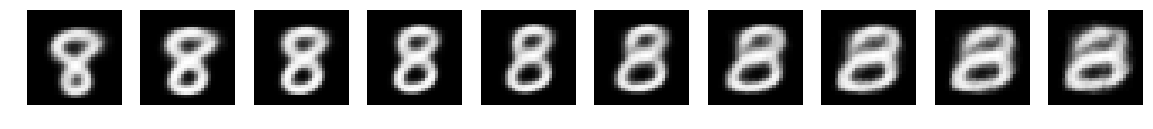

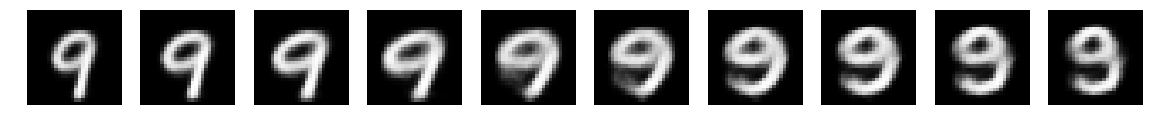

In [12]:
# exploring the latent space: change z sample on the y-axis
digit_size = 28
for cond_num in range(10):
    condition_num = to_categorical(cond_num, 10).reshape(1,-1)
    plt.figure(figsize=(20, 2))

    for i in range(10):
        z_sample = np.array([[0.3, 0.3*i]])
        x_decoded = generator.predict(np.column_stack([z_sample, condition_num]))
        digit = x_decoded[0].reshape(digit_size, digit_size)

        plt.subplot(1, 10, i+1)
        plt.axis('off')
        plt.imshow(digit, cmap='Greys_r',)

plt.show()